2000
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64


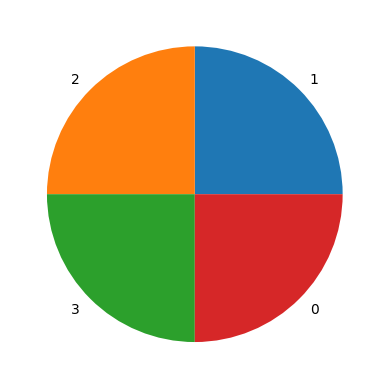

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')
print(df.shape[0])
print(df.isna().sum())

plt.pie(df['price_range'].value_counts(), labels=df['price_range'].unique())
plt.show()

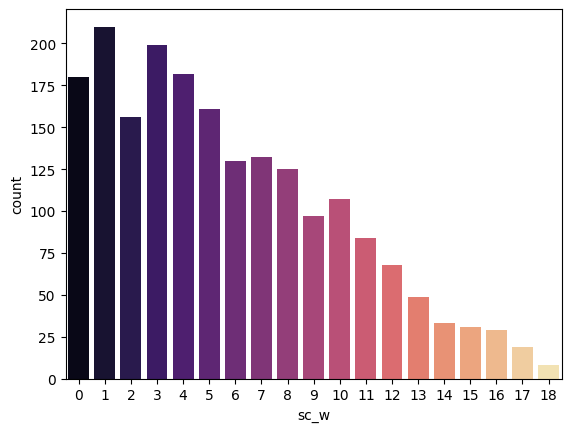

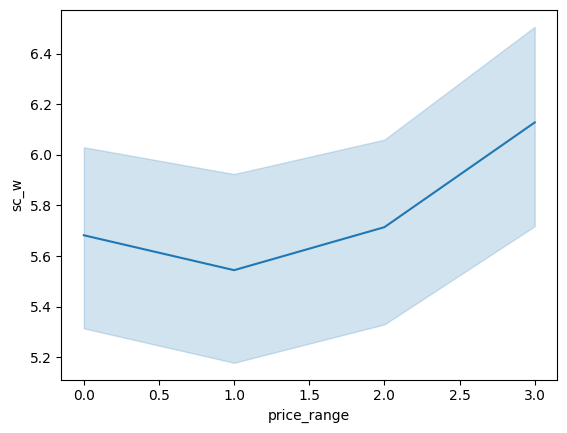

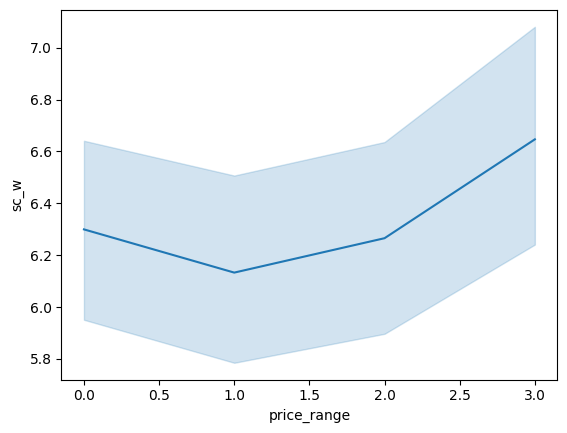

In [2]:
sns.countplot(df, x='sc_w', palette='magma')
plt.show()

sns.lineplot(df, x='price_range', y='sc_w')
plt.show()

df1 = df[df['sc_w'] > 0]
sns.lineplot(df1, x='price_range', y='sc_w')
plt.show()

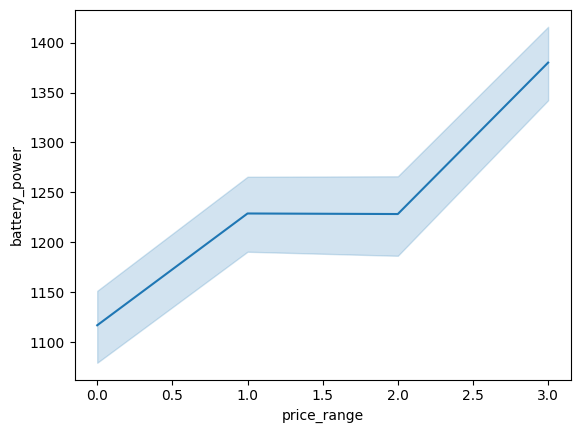

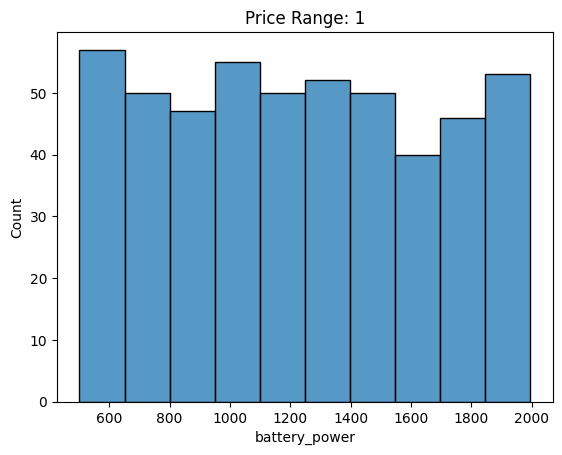

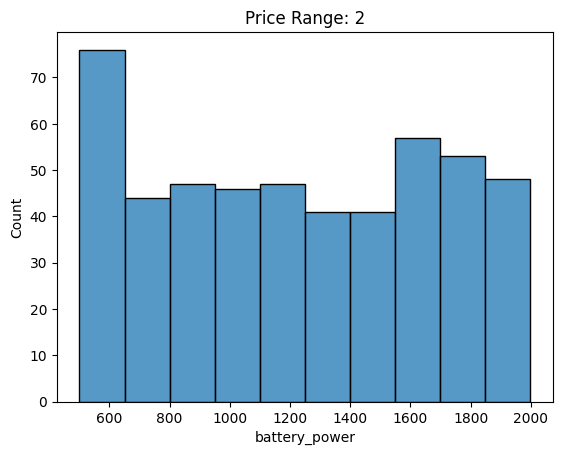

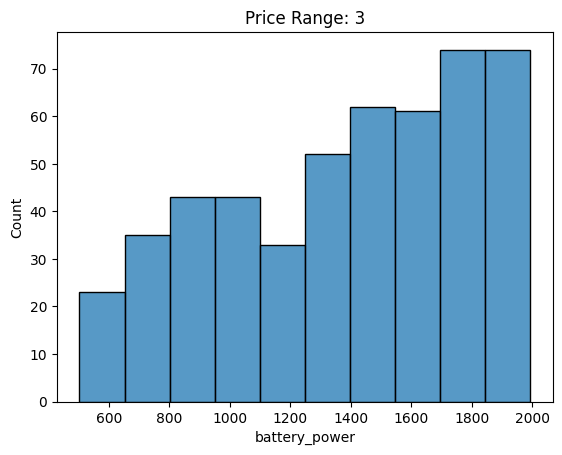

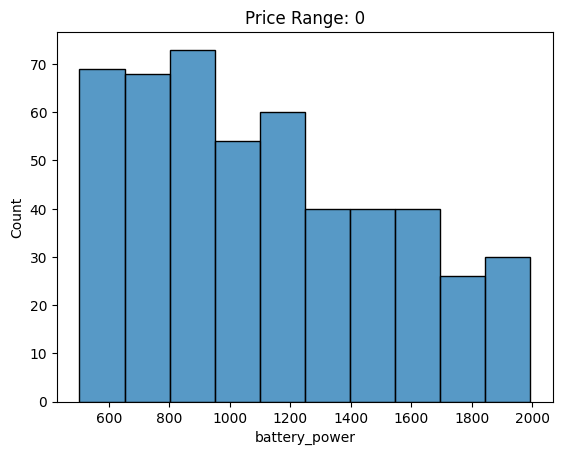

In [3]:
sns.lineplot(df, x='price_range', y='battery_power')
plt.show()

for i in df.price_range.unique():
    sns.histplot(df[df.price_range == i], x='battery_power')
    plt.title(label=f'Price Range: {i}')
    plt.show()

In [4]:
df_4g = df[df['four_g'] == 1]
print(df_4g['three_g'].value_counts())

1    1043
Name: three_g, dtype: int64


In [5]:
print(df_4g[['wifi','blue']].value_counts())

wifi  blue
0     0       263
1     1       263
0     1       260
1     0       257
dtype: int64


Predizione decision tree Test: 0.802 Train: 1.0
Predizione logistic regression Test: 0.65 Train: 0.6326666666666667


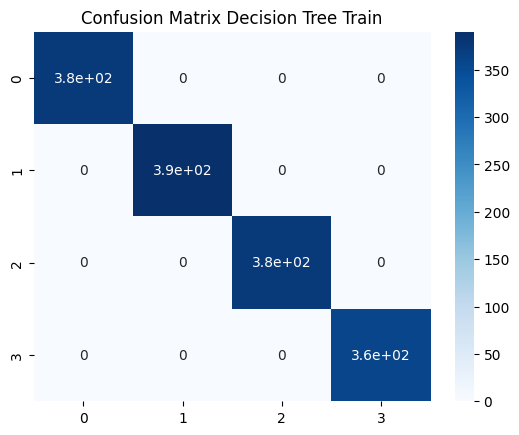

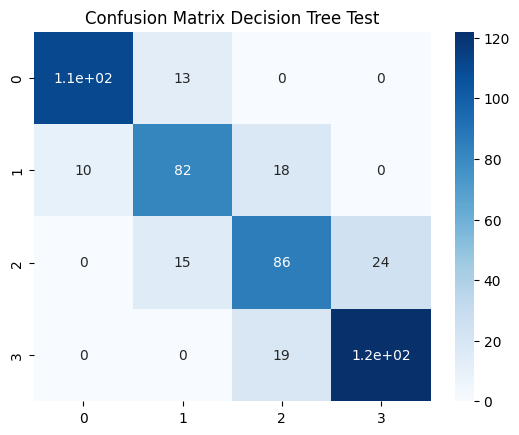

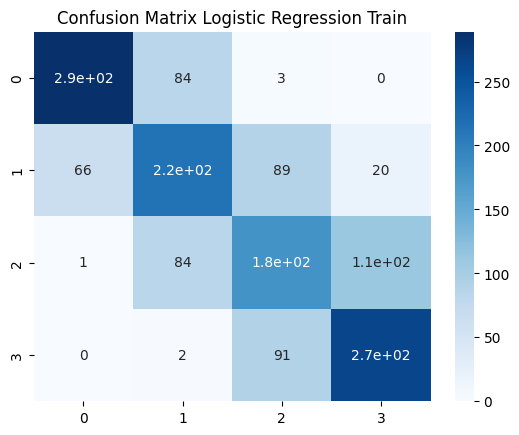

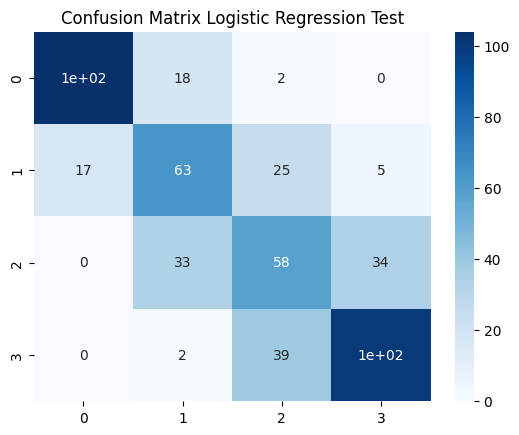

In [6]:
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

y = df['price_range']
X = df.drop('price_range', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=1/4, random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

test_pred = tree.predict(X_test)
train_pred = tree.predict(X_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

test_pred1 = logreg.predict(X_test)
train_pred1 = logreg.predict(X_train)
print(f'Predizione logistic regression Test: {accuracy_score(y_test, test_pred1)} Train: {accuracy_score(y_train, train_pred1)}')

sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_pred), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_pred), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Test')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_pred1), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_pred1), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Test')
plt.show()

In [7]:
print('Accuracy Decision Tree con Cross Val ',cross_val_score(tree, X, y, cv=10, scoring='accuracy').mean())
print('Accuracy Logistic Regression con Cross Val ',cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

Accuracy Decision Tree con Cross Val  0.8380000000000001
Accuracy Logistic Regression con Cross Val  0.6395000000000001


In [8]:
from sklearn.model_selection import GridSearchCV

params = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'min_samples_split' : [2,3,4,5,10]
}

gs = GridSearchCV(tree, param_grid=params, scoring='accuracy')
gs.fit(X_train, y_train)

test_pred = gs.predict(X_test)
train_pred = gs.predict(X_train)
print(gs.best_params_)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

{'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_split': 4}
Predizione decision tree Test: 0.698 Train: 0.9786666666666667


In [9]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

temp = scaler.fit_transform(X)
Xs = pd.DataFrame(temp, columns=scaler.get_feature_names_out())

Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=1/4, random_state=0)

tree.fit(Xs_train, y_train)
test_pred = tree.predict(Xs_test)
train_pred = tree.predict(Xs_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

Predizione decision tree Test: 0.822 Train: 1.0


In [10]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(transformers=[('discr', KBinsDiscretizer(n_bins=4), ['ram'])], remainder='passthrough')

temp = ct.fit_transform(X)
Xd = pd.DataFrame(temp, columns=ct.get_feature_names_out())

Xd_train, Xd_test, y_train, y_test = train_test_split(Xd, y, test_size=1/4, random_state=0)

tree.fit(Xd_train, y_train)
test_pred = tree.predict(Xd_test)
train_pred = tree.predict(Xd_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

Predizione decision tree Test: 0.732 Train: 1.0


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

trasf = [
    ('discr1', KBinsDiscretizer(n_bins=4), ['ram']),
    ('discr2', KBinsDiscretizer(n_bins=10), ['battery_power'])
    ]

ct = ColumnTransformer(transformers=trasf, remainder='passthrough')

pipe = Pipeline(steps=[
    ('ct', ct),
    ('norm', Normalizer())
    ])

Xp = pipe.fit_transform(X)
Xp_train, Xp_test, y_train, y_test = train_test_split(Xp, y, test_size=1/4, random_state=0)

tree.fit(Xp_train, y_train)
test_pred = tree.predict(Xp_test)
train_pred = tree.predict(Xp_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

Predizione decision tree Test: 0.736 Train: 1.0


In [12]:
test = pd.read_csv('test.csv')
test.drop('id', axis=1, inplace=True)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

test_pred = tree.predict(test)
print(f'Predizione decision tree Test: {test_pred}')

Predizione decision tree Test: [3 3 2 3 1 3 3 1 3 0 3 3 0 0 2 0 2 1 3 2 0 3 1 1 3 0 2 0 2 0 2 0 3 0 0 1 3
 1 2 1 1 1 0 0 0 1 1 3 1 2 1 0 3 0 3 1 3 1 1 3 3 2 0 1 1 1 1 3 1 2 1 2 2 3
 3 0 2 0 2 3 0 3 3 0 3 1 2 1 3 0 1 2 3 1 2 2 0 2 1 3 1 0 0 3 0 2 0 1 2 3 3
 2 1 3 3 3 3 2 3 0 0 3 2 1 1 0 3 2 3 2 0 2 1 0 3 0 2 0 3 2 1 3 1 3 2 3 3 3
 2 3 2 3 0 0 2 2 3 3 3 2 2 2 3 3 3 3 1 0 3 0 0 0 1 0 0 1 0 0 1 2 1 0 0 1 1
 2 2 1 0 0 0 1 0 3 2 1 2 2 3 2 1 2 3 2 3 2 2 0 0 0 1 3 0 3 2 3 0 2 0 3 2 2
 3 1 0 1 0 2 1 1 0 2 2 1 2 0 2 0 3 1 2 0 0 2 1 3 3 3 1 1 3 0 0 3 2 3 1 3 1
 0 3 2 1 2 3 3 3 1 0 1 2 2 1 1 3 2 0 3 0 1 2 0 0 3 2 3 3 2 1 3 3 2 3 2 2 1
 2 0 2 3 1 0 0 3 0 3 0 1 2 0 2 2 1 3 2 2 0 3 0 0 0 1 3 2 0 1 0 2 2 0 3 3 1
 2 3 2 3 1 3 3 2 2 3 3 3 0 3 1 3 1 3 1 3 3 0 1 1 3 1 3 2 3 1 0 0 0 2 0 0 2
 1 1 1 3 2 0 1 0 0 3 3 1 3 1 2 2 1 2 3 1 1 3 2 1 2 0 1 1 0 3 2 1 0 1 0 0 1
 0 0 0 0 2 2 3 1 3 0 2 1 3 0 1 1 1 1 0 3 3 3 3 1 2 2 2 1 3 2 1 1 2 1 2 0 0
 0 1 2 1 0 3 2 0 2 2 0 0 3 0 1 0 3 3 3 1 3 0 2 3 3 3 0 2 0 2 1 1 1 2 